In [1]:
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import r2_score


# Set figure size to (12, 6)
plt.rcParams['figure.figsize'] = (12,6)
warnings.simplefilter('ignore')

## Load data from .txt file

In [2]:
df = pd.read_csv('/Users/julia/Documents/SPICED/_data/ECA_Tempelhof/TG_STAID002759.txt', header=14)
df

,SOUID,DATE,TG,Q_TG
0,127488,18760101,22,0
1,127488,18760102,25,0
2,127488,18760103,3,0
3,127488,18760104,-58,0
4,127488,18760105,-98,0
...,...,...,...,...
52711,111448,20200426,124,0
52712,111448,20200427,151,0
52713,111448,20200428,170,0
52714,111448,20200429,120,0


## Create necessary columns and select relevant data

In [3]:
#get rid of whitespace in column names
df.columns = [x.strip() for x in df.columns]

In [4]:
df['datetime'] = pd.to_datetime(df['DATE'], format='%Y%m%d')
df['temp'] = df['TG']/10
df['year'] = df['datetime'].dt.year
df['month'] = df['datetime'].dt.month
df['day'] = df['datetime'].dt.day
df['month-day'] = df['datetime'].dt.strftime("%m-%d")

In [5]:
df = df[(df['datetime'].dt.year >= 1950) & (df['datetime'].dt.year < 2020)]

In [6]:
df.head()

,SOUID,DATE,TG,Q_TG,datetime,temp,year,month,day,month-day
27028,111448,19500101,-35,0,1950-01-01,-3.5,1950,1,1,01-01
27029,111448,19500102,10,0,1950-01-02,1.0,1950,1,2,01-02
27030,111448,19500103,29,0,1950-01-03,2.9,1950,1,3,01-03
27031,111448,19500104,-1,0,1950-01-04,-0.1,1950,1,4,01-04
27032,111448,19500105,-30,0,1950-01-05,-3.0,1950,1,5,01-05


(731947.0, 735599.0)

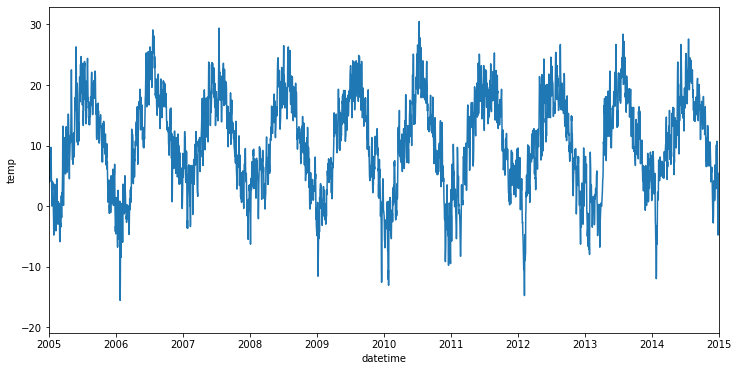

In [7]:
ax = sns.lineplot(x='datetime', y='temp', data=df)
ax.set_xlim(pd.to_datetime('2005'), pd.to_datetime('2015'))

<Figure size 432x1296 with 0 Axes>

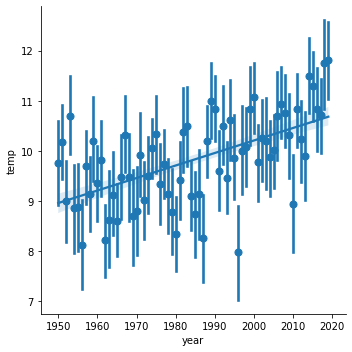

In [8]:
plt.figure(figsize=(6,18))
ax = sns.lmplot(x="year", y="temp", data=df, x_estimator=np.mean)

## Train-test split

In [9]:
# train test split is a little bit different for time-dependent data
Xtrain = df[df['datetime'] < pd.to_datetime('2005-01-01')]
Xtest = df[df['datetime'] >= pd.to_datetime('2005-01-01')].drop('temp', axis=1)
ytrain = df[df['datetime'] < pd.to_datetime('2005-01-01')]['temp']
ytest = df[df['datetime'] >= pd.to_datetime('2005-01-01')]['temp']

Xtrain.shape, Xtest.shape, ytrain.shape, ytest.shape

((20089, 10), (5478, 9), (20089,), (5478,))

(730120.0, 733773.0)

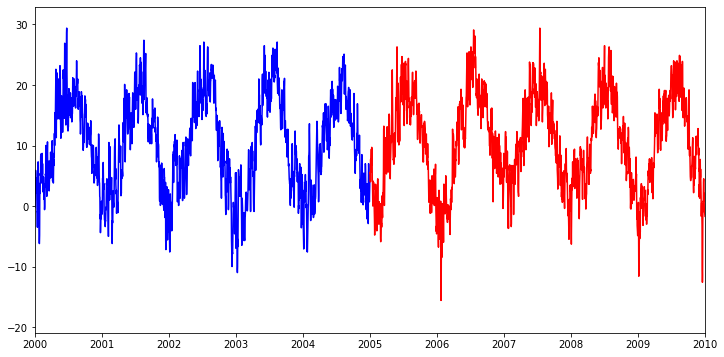

In [10]:
ax = plt.plot(Xtrain['datetime'], ytrain, 'b-')
plt.plot(Xtest['datetime'], ytest, 'r-')
plt.xlim(pd.to_datetime('2000'), pd.to_datetime('2010'))

## Stationarize data
**1. Remove the trend - differencing**

In [13]:
Xtrain['diff'] = ytrain.diff().fillna(0)
ytest_diff = ytest.diff().fillna(0) #actually we don't have that data

(730120.0, 733773.0)

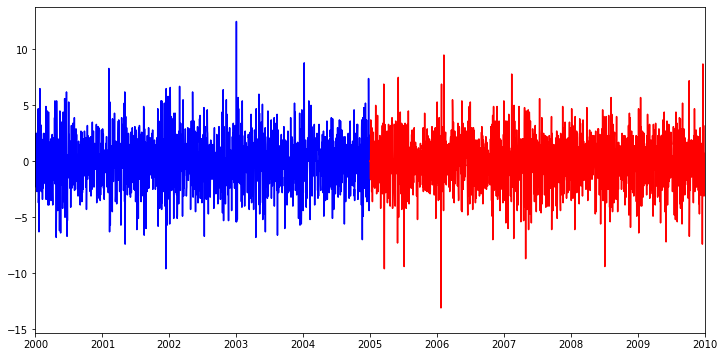

In [14]:
ax = plt.plot(Xtrain['datetime'], Xtrain['diff'], 'b-')
plt.plot(Xtest['datetime'], ytest_diff, 'r-')
plt.xlim(pd.to_datetime('2000'), pd.to_datetime('2010'))

### Remove seasonality

In [15]:
Xtrain['daily_mean'] = Xtrain.groupby('month-day')['diff'].transform('mean')
Xtrain['deseason'] = Xtrain['diff'] - Xtrain['daily_mean']

(730120.0, 733773.0)

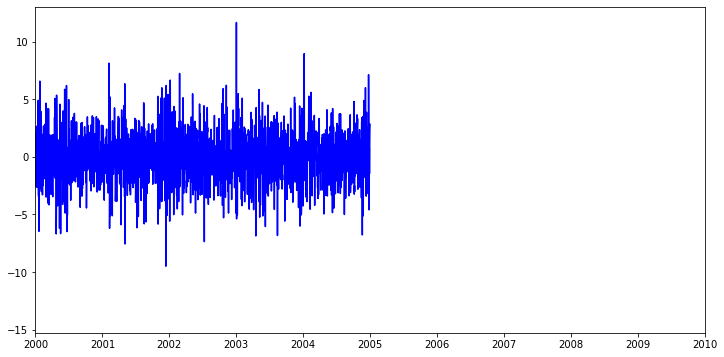

In [16]:
ax = plt.plot(Xtrain['datetime'], Xtrain['deseason'], 'b-')
#plt.plot(Xtest['datetime'], ytest_diff, 'r-')
plt.xlim(pd.to_datetime('2000'), pd.to_datetime('2010'))


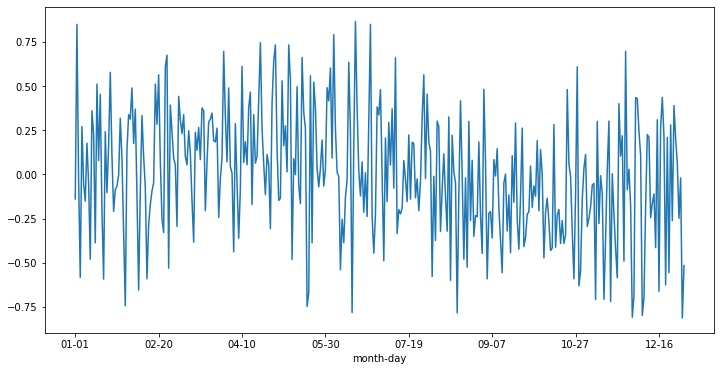

In [19]:
# mean temperatures of each day in the year
Xtrain.groupby(['month-day'])['diff'].mean().plot()

In [20]:
Xtrain['deseason'].mean(), Xtrain['deseason'].std()

(5.349673392588738e-18, 2.387527370978747)

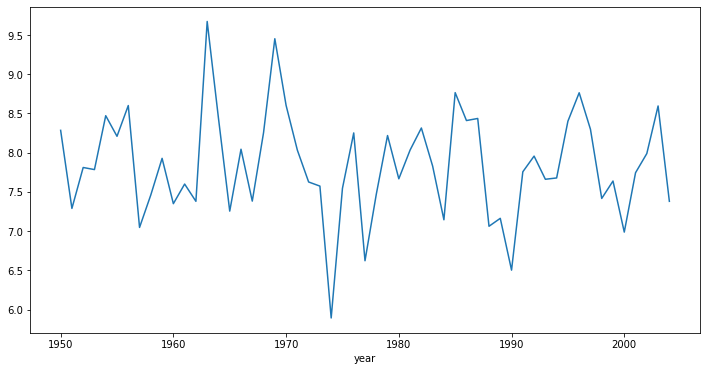

In [21]:
# check if volatility changes over time
Xtrain.groupby(['year'])['temp'].std().plot()

### Naive forecast - predict daily mean

In [22]:
df['month-day'] = df['datetime'].dt.strftime("%m-%d")
daily_means = dict(Xtrain.groupby(['month-day'])['temp'].mean())
ypred_dailymean = Xtest['month-day'].replace(daily_means)
r2_score(ytest, ypred_dailymean)

0.7468749740708021

(730120.0, 733773.0)

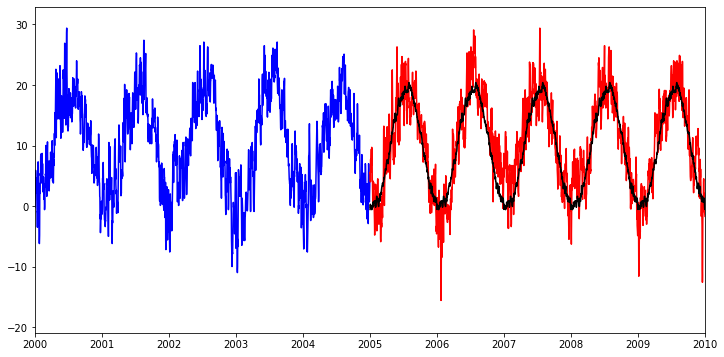

In [30]:
ax = plt.plot(Xtrain['datetime'], ytrain, 'b-')
plt.plot(Xtest['datetime'], ytest, 'r-')
plt.plot(Xtest['datetime'], ypred_dailymean, 'k-')
plt.xlim(pd.to_datetime('2000'), pd.to_datetime('2010'))

### ARIMA

In [27]:
days_forecasted = 365
m = ARIMA(ytrain, order=(3,0,3)) # parameters from above in order p,d,q
# 3 days back, 0 difference (we have already done that manually), warning if no freq value is set, but thats okay
m_fit = m.fit()
output = m_fit.forecast(days_forecasted) 

fc = []
for i in range(365):
    # reinialize the model
    ytrain_new = data[:150 + i]
    m = ARIMA(ytrain_new, (2, 0, 0))
    m.initialize()
    r = m.fit()
    # do a forecast 3 periods ahead
    ypred, err, conf = r.forecast(steps=3) # predicted, error, confidence
    # collect the last forecasted point
    fc.append(ypred[0])

In [28]:
ypred = output[0]
err = output[1] # error
conf = output[2] # confidence

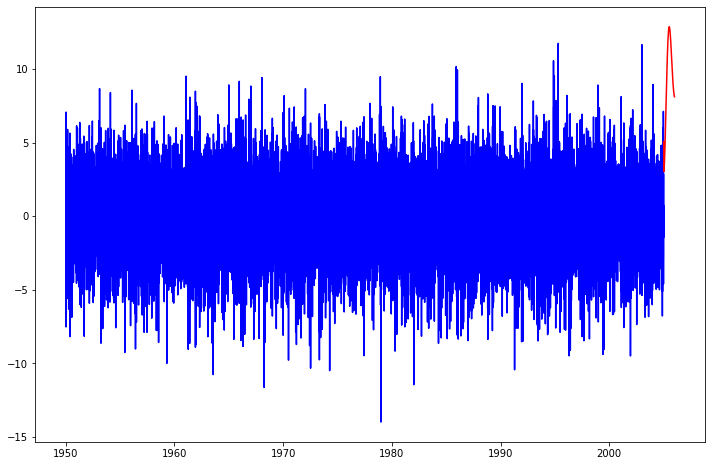

In [29]:
plt.figure(figsize=(12,8))
plt.plot(Xtrain['datetime'], Xtrain['deseason'], color='blue')
plt.plot(Xtest['datetime'][:days_forecasted], ypred, color='red')